(2, 1000) (1000,)


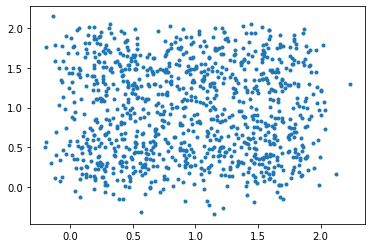

In [259]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pickle

# load data
D = pickle.load(open("xorData.p", "rb"))
# print(D)

X = D.data
y = D.target

print(X.shape, y.shape)
# print(X1[:,0])

plt.figure()
plt.plot(X[0, :], X[1, :], '.')
# plt.plot(y1, y1, '.')
plt.show()


### Network training algorithm a)


In [260]:
def train(
    X=X,
    y=y,
    hidden_units=10,
    adaptation_step=1e-5,  # eta
    moment_term=0.9,  # alpha
    number_of_iterations=3000,  # iter
    activation_function=np.tanh,
):

    # Each row for each input
    # Each column for each hidden neuron
    # Start the hidden layer weights with low random values
    Wi = rd.randn(2, hidden_units) * .1
    # print(Wi)

    # Each row for each hidden neuron
    b = np.zeros((hidden_units, 1))
    # print(b)

    # Each row for the output of each hidden neuron
    # Start the output layer weights with low random values
    Wo = rd.randn(hidden_units, 1) * .1
    # print(Wo)

    # Bias for the output layer
    bo = 0

    # Initialize the derivatives
    dzWi = np.zeros(Wi.shape)
    dzb = np.zeros(b.shape)
    dzWo = np.zeros(Wo.shape)
    dzbo = 0

    Error = np.zeros(number_of_iterations)

    for n in range(number_of_iterations):
        # forward pass
        u = np.dot(Wi.T, X) + b
        v = activation_function(u)
        z = np.dot(Wo.T, v) + bo
        yh = activation_function(z)

        # error
        E = y-yh
        Error[n] = np.mean(E**2)

        # gradient
        dz = -2*E*(1-yh**2)
        dbo = np.sum(dz)
        dWo = np.dot(v, dz.T)
        du = (1-v**2)*np.dot(Wo, dz)
        db = np.sum(du, axis=1)
        dWi = np.dot(X, du.T)

        # adapt
        dzWi = moment_term * dzWi + dWi
        dzb = moment_term * dzb + db[:, np.newaxis]
        dzWo = moment_term * dzWo + dWo
        dzbo = moment_term * dzbo + dbo

        Wi = Wi - adaptation_step * dzWi
        b = b - adaptation_step * dzb
        Wo = Wo - adaptation_step * dzWo
        bo = bo - adaptation_step * dzbo

    return Error, yh, Wi, b, Wo, bo


### Train network b) c) d)


Best 0.20329967783173886 0.0007800000000000001 0.91


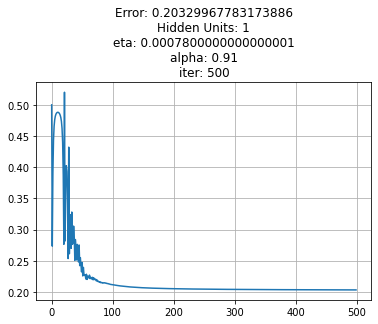

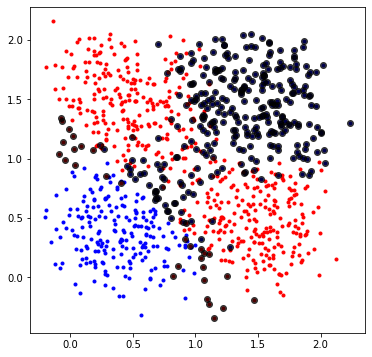

Nº of errors: 324


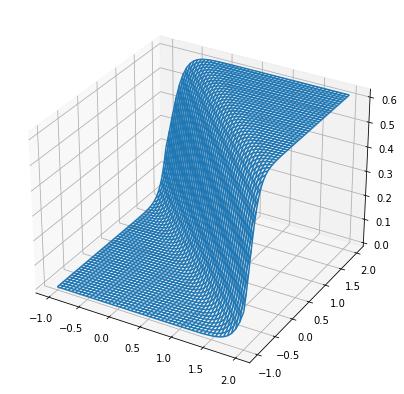

Best 0.05997384734440023 0.00023 0.98


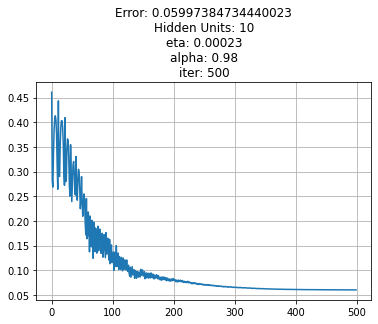

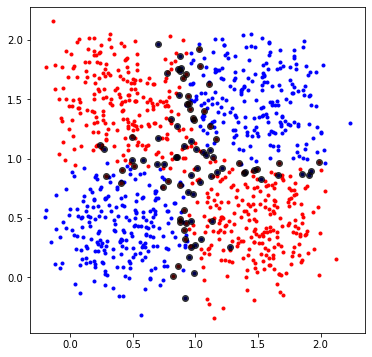

Nº of errors: 84


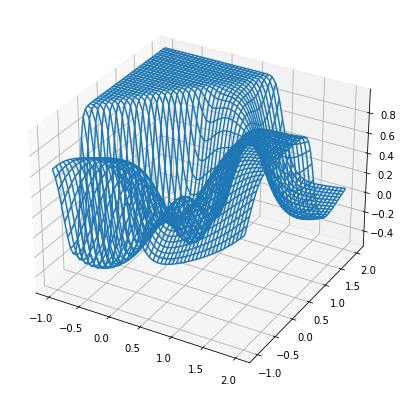

Best 0.06352237451776975 0.00012 0.98


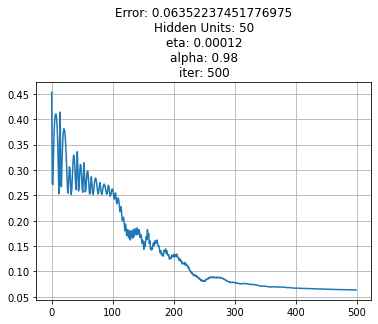

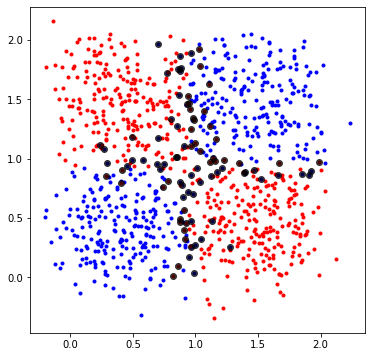

Nº of errors: 87


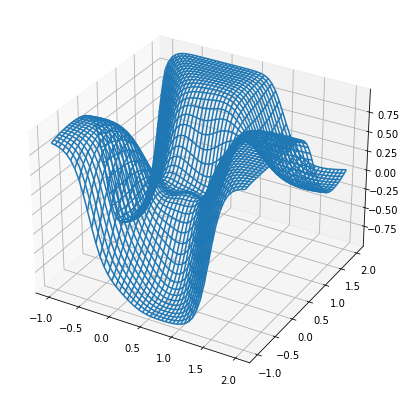

In [261]:
# For 1, 10 and 50 hidden units
for hu in [1, 10, 50]:
    best = 1
    best_error = []
    best_yh = []
    best_eta = 0
    best_alpha = 0
    best_Wi = []
    best_b = []
    best_Wo = []
    best_bo = 0
    for eta in np.linspace(1e-5, 1e-3, 10):
        for alpha in np.linspace(0.9, 0.99, 10):
            Error, yh, Wi, b, Wo, bo = train(X, y,
                                             hidden_units=hu,
                                             adaptation_step=eta,  # eta
                                             moment_term=alpha,  # alpha
                                             number_of_iterations=500,  # iter
                                             )

            if Error[len(Error)-1] < best:
                best = Error[len(Error)-1]
                best_error = Error.copy()
                best_yh = yh.copy()
                best_Wi = Wi.copy()
                best_b = b.copy()
                best_Wo = Wo.copy()
                best_bo = bo
                best_eta = eta
                best_alpha = alpha

    plt.figure()
    plt.plot(best_error)
    plt.title('Error: ' + str(best) +
              '\nHidden Units: ' + str(hu) +
              '\neta: ' + str(best_eta) +
              '\nalpha: ' + str(best_alpha) +
              '\niter: ' + str(len(best_error)))
    plt.grid(True)
    plt.show()

    # Training set errors

    plt.figure(figsize=(6, 6))
    ye = (best_yh.squeeze() >= 0.5)
    plt.plot(X[0, y == 0], X[1, y == 0], '.b')
    plt.plot(X[0, y == 1], X[1, y == 1], '.r')
    plt.plot(X[0, y != ye], X[1, y != ye], 'ok', alpha=.7)
    plt.show()
    print('Nº of errors:', np.sum(y != ye))

    # Wireframe

    gX, gY = np.meshgrid(np.linspace(-1, 2, 50), np.linspace(-1, 2, 50))
    X2 = np.vstack((gX.ravel(), gY.ravel()))
    u = np.dot(best_Wi.T, X2)+best_b
    v = np.tanh(u)
    z = np.dot(best_Wo.T, v)
    yh = np.tanh(z+best_bo)
    Yh = np.reshape(yh, (50, 50))

    fig = plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    # ax.contour3D(gX,gY,Yh,50,cmap='binary')
    ax.plot_wireframe(gX, gY, Yh)
    plt.show()


We can see that when we train with 1 hidden unit, the network is not able to learn the function because with only 1 hidden unit, there's no way differentiate the data with an intersection

With 10 or 50 units we see not much difference, indicating that adding more hidden units is not usefull. Maybe a better result cloud be achieved incresing the number of hidden layers instead of the number of hidden units